In [3]:
import os
import logging
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from monai.networks.nets import resnet18  # Import ResNet18 from MONAI
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.metrics import accuracy
from fastai.losses import CrossEntropyLossFlat
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline

In [4]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("heart_disease_model.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


In [5]:
class NPYDataset(Dataset):
    """
    Custom PyTorch Dataset for loading 3D medical imaging data from .npy files.
    """
    def __init__(self, dataframe, image_column_name, label_column_name):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing the data.
            image_column_name (str): Name of the column containing the image file paths.
            label_column_name (str): Name of the column containing the labels.
        """
        self.dataframe = dataframe
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name

        # Transformation pipeline
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),  # Flip frames horizontally
            transforms.RandomRotation(degrees=15),  # Apply slight rotations
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Apply affine transformations
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Load and preprocess a single sample.
        """
        try:
            npy_path = self.dataframe[self.image_column_name].iloc[idx]
            label = self.dataframe[self.label_column_name].iloc[idx]

            # Load the 3D array (30 frames, 200x200 pixels)
            image = np.load(npy_path)  # Shape: (30, 200, 200)

            # Select exactly 18 frames
            image = image[6:24, :, :]  # Shape: (18, 200, 200)

            # Convert to tensor and add channel dimension
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 18, 200, 200)

            # Resize spatial dimensions to 112x112
            image = F.interpolate(image, size=(112, 112), mode='bilinear', align_corners=False)

            # Apply transformations
            image = self.transform(image)

            return image, label

        except Exception as e:
            logger.error(f"Error loading image at index {idx}: {e}")
            raise


class HeartDiseaseModel:
    """
    Model for classifying heart disease using 3D medical imaging data.
    """
    def __init__(self, train_dataframe_path, test_dataframe_path, image_column_name, label_column_name,
                 batch_size=8, split_ratio=0.90, model_name='best_model', pretrained_weights_path=None):
        self.train_dataframe_path = train_dataframe_path
        self.test_dataframe_path = test_dataframe_path
        self.image_column_name = image_column_name
        self.label_column_name = label_column_name
        self.batch_size = batch_size
        self.split_ratio = split_ratio
        self.model_name = model_name
        self.pretrained_weights_path = pretrained_weights_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Logging
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.info(f"Using device: {self.device}")

        # Prepare data and model
        self._prepare_data()
        self._prepare_model()

    def _prepare_data(self):
        """
        Prepare the training, validation, and test datasets and data loaders.
        """
        try:
            # Load dataframes
            train_df = pd.read_csv(self.train_dataframe_path)
            test_df = pd.read_csv(self.test_dataframe_path)

            # Create dataset
            dataset = NPYDataset(train_df, self.image_column_name, self.label_column_name)

            # Split train and validation datasets
            train_size = int(self.split_ratio * len(dataset))
            val_size = len(dataset) - train_size
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(
                dataset, [train_size, val_size]
            )

            # Create data loaders
            self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)
            self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)

            # Create test dataset and loader
            self.test_dataset = NPYDataset(test_df, self.image_column_name, self.label_column_name)
            self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)

            self.logger.info("Data preparation completed successfully")

        except Exception as e:
            self.logger.error(f"Error in data preparation: {e}")
            raise

    def _prepare_model(self):
        """
        Initialize the model and load pretrained weights.
        """
        try:
            # Initialize ResNet18 from MONAI
            self.model = resnet18(spatial_dims=3, n_input_channels=1, num_classes=2)

            # Load pretrained weights
            if self.pretrained_weights_path:
                self.logger.info("Loading pretrained weights...")
                state_dict = torch.load(self.pretrained_weights_path)
                self.model.load_state_dict(state_dict, strict=False)

            # Use DataParallel for multi-GPU support
            self.model = nn.DataParallel(self.model)
            self.model.to(self.device)

            # Prepare FastAI Learner
            self.dls = DataLoaders(self.train_loader, self.val_loader)
            self.learn = Learner(
                self.dls,
                self.model,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                wd=1e-4,  # Weight decay to reduce overfitting
                cbs=[
                    SaveModelCallback(fname=self.model_name, monitor='valid_loss'),
                    EarlyStoppingCallback(monitor='valid_loss', patience=10)
                ]
            ).to_fp16()

            self.logger.info("Model preparation completed successfully")

        except Exception as e:
            self.logger.error(f"Error in model preparation: {e}")
            raise

    def train(self, lr=1e-5, epochs=50):
        """
        Train the model.
        """
        try:
            self.logger.info("Starting training...")
            self.learn.fine_tune(epochs, base_lr=lr)
            self.logger.info("Training completed successfully")

        except Exception as e:
            self.logger.error(f"Error during training: {e}")
            raise

    def evaluate(self):
        """
        Evaluate the model on validation and test datasets.
        """
        try:
            self.logger.info("Evaluating on validation data...")
            self._evaluate_data(self.val_loader, "Validation")

            self.logger.info("Evaluating on test data...")
            self._evaluate_data(self.test_loader, "Test")

        except Exception as e:
            self.logger.error(f"Error during evaluation: {e}")
            raise

    def _evaluate_data(self, data_loader, dataset_name):
        preds, targs = self._get_predictions(data_loader)
        self._print_classification_report(targs, preds, dataset_name)
        self._plot_confusion_matrix(targs, preds, dataset_name)

    def _get_predictions(self, data_loader):
        preds, targs = [], []
        self.model.eval()
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                preds.extend(predicted.cpu().numpy())
                targs.extend(labels.cpu().numpy())
        return preds, targs

    def _print_classification_report(self, targs, preds, dataset_name):
        report = classification_report(targs, preds, target_names=["No CAD", "CAD"])
        self.logger.info(f"Classification Report for {dataset_name} Data:\n{report}")

    def _plot_confusion_matrix(self, targs, preds, dataset_name):
        cm = confusion_matrix(targs, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No CAD", "CAD"], yticklabels=["No CAD", "CAD"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix for {dataset_name} Data")
        plt.show()

2024-12-03 19:00:20,525 - HeartDiseaseModel - INFO - Using device: cuda
2024-12-03 19:00:21,392 - HeartDiseaseModel - INFO - Data preparation completed successfully
2024-12-03 19:00:22,614 - HeartDiseaseModel - INFO - Loading pretrained weights...
/tmp/ipykernel_3549765/3311561986.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=

epoch,train_loss,valid_loss,accuracy,time
0,0.686930,0.678123,0.583193,02:26


Better model found at epoch 0 with valid_loss value: 0.6781234741210938.


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locat

epoch,train_loss,valid_loss,accuracy,time
0,0.673506,0.679077,0.588235,00:37
1,0.674156,0.673810,0.586555,00:38
2,0.672121,0.668597,0.605042,00:38
3,0.668942,0.661555,0.593277,00:38
4,0.666393,0.664416,0.615126,00:37
5,0.663342,0.688483,0.581513,00:38
6,0.661896,0.667050,0.601681,00:38
7,0.653686,0.658692,0.615126,00:38
8,0.654281,0.706546,0.571429,00:38
9,0.657953,0.707607,0.564706,00:38


Better model found at epoch 0 with valid_loss value: 0.6790774464607239.
Better model found at epoch 1 with valid_loss value: 0.6738095283508301.
Better model found at epoch 2 with valid_loss value: 0.6685972809791565.
Better model found at epoch 3 with valid_loss value: 0.6615552306175232.
Better model found at epoch 7 with valid_loss value: 0.6586923599243164.
Better model found at epoch 11 with valid_loss value: 0.651178777217865.
Better model found at epoch 13 with valid_loss value: 0.6452256441116333.
Better model found at epoch 17 with valid_loss value: 0.6442086100578308.
Better model found at epoch 18 with valid_loss value: 0.6331799030303955.
Better model found at epoch 27 with valid_loss value: 0.6300956606864929.
No improvement since epoch 27: early stopping


2024-12-03 19:27:19,751 - HeartDiseaseModel - INFO - Training completed successfully
2024-12-03 19:27:19,766 - HeartDiseaseModel - INFO - Evaluating on validation data...
2024-12-03 19:27:23,045 - HeartDiseaseModel - INFO - Classification Report for Validation Data:
              precision    recall  f1-score   support

      No CAD       0.68      0.69      0.69       326
         CAD       0.62      0.61      0.61       269

    accuracy                           0.65       595
   macro avg       0.65      0.65      0.65       595
weighted avg       0.65      0.65      0.65       595



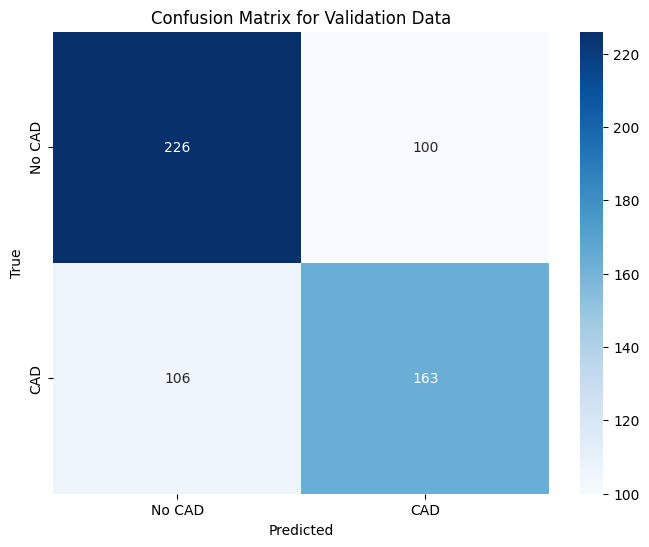

2024-12-03 19:27:23,630 - HeartDiseaseModel - INFO - Evaluating on test data...
2024-12-03 19:27:33,752 - HeartDiseaseModel - INFO - Classification Report for Test Data:
              precision    recall  f1-score   support

      No CAD       0.60      0.71      0.65       200
         CAD       0.65      0.53      0.58       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400



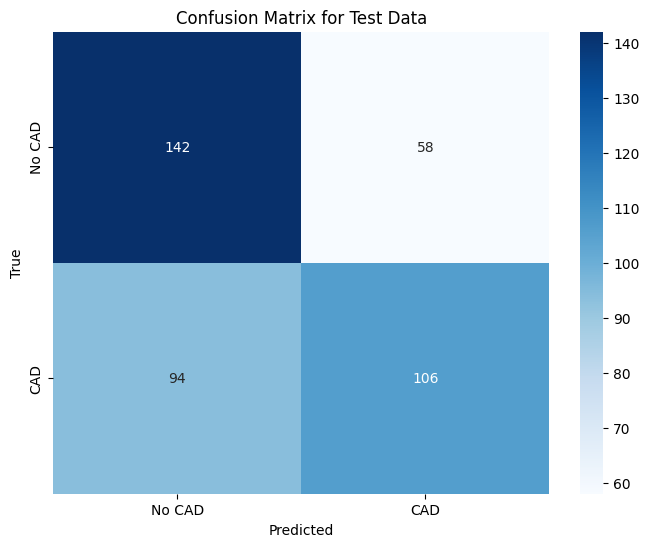

In [6]:
if __name__ == "__main__":
    model = HeartDiseaseModel(
        train_dataframe_path="Final_Datasets/train_resnet_blood_flow.csv",
        test_dataframe_path="Final_Datasets/test_data_incidence.csv",
        image_column_name="FilePath_bf",
        label_column_name="CAD",
        model_name="heart_blood_flow_Med3D_resnet18",
        pretrained_weights_path="../Med3D/resnet_18_23dataset.pth"
    )
    model.train(epochs=50, lr=1e-5)
    model.evaluate()